# Experiment 3.1: Dropping layers.

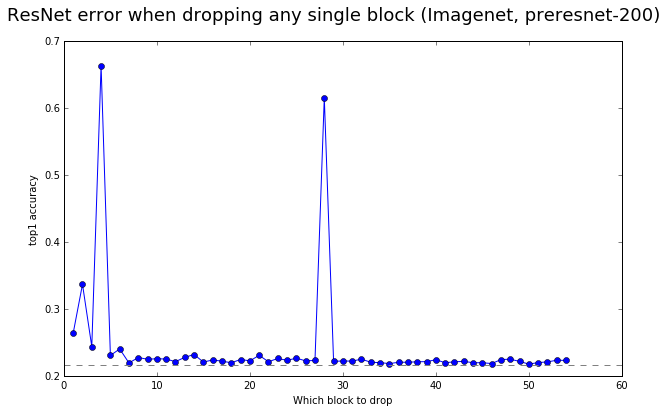

 0.21654
Baseline error:  0.78346



Baseline accuracy: 

/Users/michael/fb.resnet.torch-lesion-study
Populating the interactive namespace from numpy and matplotlib

In [1]:
%cd ~/fb.resnet.torch-lesion-study/
%pylab inline
import msgpack
def get_results(name=None):
    try:
        with open(name) as f:
            results = msgpack.load(f)
            total = np.array([r['total'] for r in results])
            correct1 = np.array([r['correct1'] for r in results])
            if correct1 is not None:
                return 1.0 - (float(correct1.sum()) / float(total.sum())) 
    except:
        return None


# Imagenet results
Xs = np.arange(55)
Ys = [get_results("lesion-study-outs-200/remove-%d.msgpack"%x)
      for x in Xs
      ]

baseline_acc = get_results(name="lesion-study-outs-200/baseline.msgpack")
print "Baseline accuracy: ", baseline_acc
print "Baseline error: ", (1.-baseline_acc)

fig,ax = subplots(figsize=(10,6))
ax.plot(Xs,Ys, marker="o")
fig.suptitle("ResNet error when dropping any single block (Imagenet, preresnet-200)", fontsize=18)
ax.set_xlabel("Which block to drop")
ax.set_ylabel("top1 accuracy")
ax.plot([0,1], [baseline_acc, baseline_acc], "--", c="gray",
        transform=ax.get_yaxis_transform())
#ax.set_ylim(0.740, 0.785)

## CIFAR-10 results

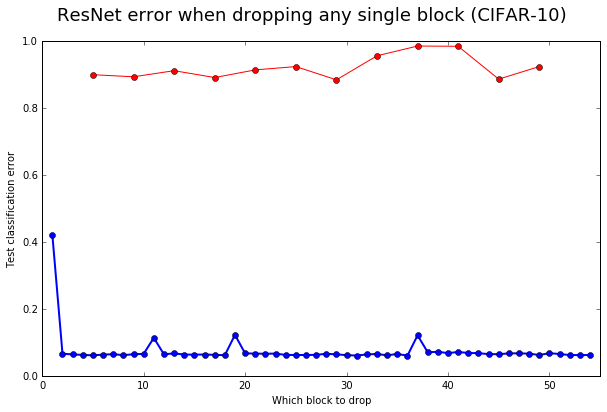

(0, 1.0)

In [24]:
def plot_drop_layer_curve(ax, tag, label, baseline_acc, **kwargs):
    Xs = np.arange(55)
    Ys = [get_results("lesion-study-outs-cifar10/%s/remove-%d.msgpack"%(tag,x))
        for x in Xs
        ]
    number_of_layers = float(sum([y is not None for y in Ys]))
    ax.plot(Xs, Ys, label=label, lw=2, **kwargs)
    # ax.plot([0,1], [0.01*baseline_acc, 0.01*baseline_acc], "--", c='gray',
    #         transform=ax.get_yaxis_transform())
    fig.suptitle("ResNet error when dropping any single block (CIFAR-10)", fontsize=18)
    ax.set_xlabel("Which block to drop")
    ax.set_ylabel("Test classification error")

fig,ax = subplots(sharey=True, figsize=(10,6))
ax.plot([5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49],
1.0 - 0.01*np.array([10.06, 10.69, 8.87, 10.91, 8.63, 7.64, 11.59, 4.42, 1.5, 1.58, 11.39, 7.63]),
marker='o', c='red')
plot_drop_layer_curve(ax, "201604300038-N15yIkvxtk", "Pre-resnet, depth = 110", 6.032, marker='o')
ax.set_xlim((0,55))
ax.set_ylim(0,1.0)

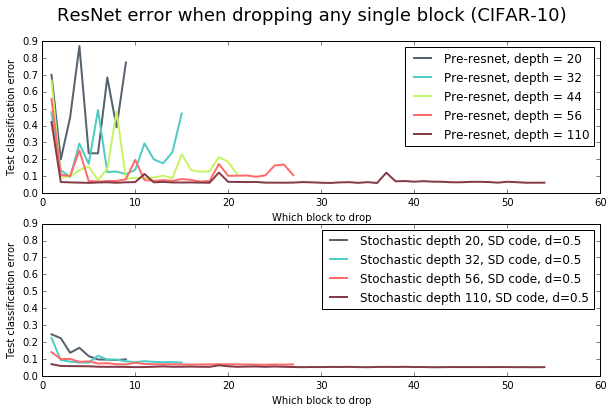

In [77]:
### CIFAR-10 results!
c20,c32,c44,c56,c110 = "#556270 #4ECDC4 #C7F464 #FF6B6B #843D48".split()

fig,(ax1,ax2) = subplots(2, sharey=True, figsize=(10,6))
plot_drop_layer_curve(ax1, "201604291727-yVXYFcNR6W", "Pre-resnet, depth = 20", 8.495, c20)
plot_drop_layer_curve(ax1, "201604291731-rn3CpTdqeL", "Pre-resnet, depth = 32", 7.674, c32)
plot_drop_layer_curve(ax1, "201604291732-QslicJIuqp", "Pre-resnet, depth = 44", 6.982, c44)
plot_drop_layer_curve(ax1, "201604291732-Xqkr0EN2aU", "Pre-resnet, depth = 56", 6.557, c56)
plot_drop_layer_curve(ax1, "201604300038-N15yIkvxtk", "Pre-resnet, depth = 110", 6.032, c110)

plot_drop_layer_curve(ax2, "201605021321-5YS8RgUYfJ", "Stochastic depth 20, SD code, d=0.5", 8.871, c20)
plot_drop_layer_curve(ax2, "201605021320-z6sLdQC8Wk", "Stochastic depth 32, SD code, d=0.5", 7.397, c32)
plot_drop_layer_curve(ax2, "201605021319-1IONyn4YoO", "Stochastic depth 56, SD code, d=0.5", 6.853, c56)
plot_drop_layer_curve(ax2, "201605011325-QrNU5qyCqw", "Stochastic depth 110, SD code, d=0.5", 5.133, c110)

ax1.legend()
ax2.legend()
#ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

In [0]:
""" ABANDONED!!
### Classwise Accuracy

Ys = np.array([(correct1 - baseline_correct1) / total.astype('float')
               for x in Xs
               if get_results(x)
               for total,correct1 in [get_results(x)]
])

fig,ax = subplots()
sorted_ys = Ys.T
sorted_ys = sorted_ys[np.argsort(Ys.sum(0))]
# sorted_ys = np.sort(sorted_ys,0)
f,cb = fig,colorbar(ax.matshow(sorted_ys, cmap='viridis'))
cb.set_label("Accuracy p.p. increase over baseline")
ax.set_aspect('auto')
ax.set_xlabel("Which layer is dropped")
ax.set_ylabel("Class index (sorted by average class accuracy)")
ax.set_title("How important are different layers to different classes?", fontsize=16)
"""

# Large-scale permutation, duplication, deletion experiments

In [78]:
%cd ~/fb.resnet.torch-lesion-study/
%pylab inline
import json
import os
import msgpack
from glob import glob
def all_experiments(path="lesion-study-outs-200/large-scale/"):
    for metadata_file in glob(path+"/*-metadata.json"):
        with open(metadata_file) as f:
            metadata = json.load(f)
            if os.path.exists(metadata['result_file']):
                with open(metadata['result_file']) as f_result:
                    results = msgpack.load(f_result)
                    metadata['results'] = results
                    yield metadata
def accuracy(experiment, type='correct1'):
    return (float(sum(cls[type] for cls in experiment['results']))
            /
            float(sum(cls['total'] for cls in experiment['results'])))
def make_filter(kind):
    def filter_experiments(experiments):
        for exp in experiments:
            if exp[kind]:
                yield exp
    return filter_experiments
only_duplicate = make_filter('duplicate')
only_permute = make_filter('permute')
only_delete = make_filter('delete')

def plot_experiment(experiments, xfun, yfun = accuracy, xlabel='', ylabel='Accuracy', title=''):
    fig,ax = subplots()
    xs, ys = zip(*[ (xfun(exp), yfun(exp))
                    for exp in experiments
                    if xfun(exp) is not None and yfun(exp) is not None
    ])
    ax.scatter(xs, ys)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=18)
    return fig,ax

/Users/michael/fb.resnet.torch-lesion-study
Populating the interactive namespace from numpy and matplotlib


In [79]:
print len(list(only_duplicate(all_experiments())))
print len(list(only_permute(all_experiments())))
print len(list(only_delete(all_experiments())))


100

76
84

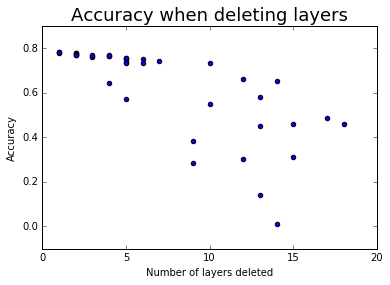

In [33]:
TRANSFORMATION_LAYERS = {1, 4, 28, 60, 61}

fig,ax = plot_experiment(only_delete(all_experiments()),
                         xfun = lambda exp: len(exp['delete']) if not set(exp['delete'])&TRANSFORMATION_LAYERS else None,
                         xlabel = 'Number of layers deleted',
                         title = 'Accuracy when deleting layers'
)

# TODO: only plot the experiments that do not drop our transformation layers


In [0]:
for exp in sorted(all_experiments(),
                  key = accuracy):
    if exp['delete']:
        if not set(exp['delete'])&TRANSFORMATION_LAYERS:
            print accuracy(exp), sorted(exp['delete'])

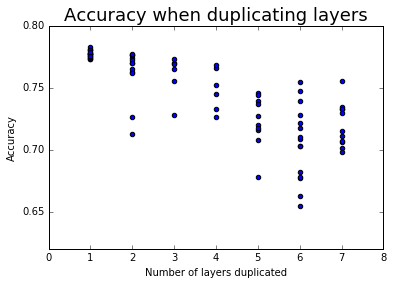

In [8]:
fig,ax = plot_experiment(only_duplicate(all_experiments()),
                         xfun = lambda exp: len(exp['duplicate']),
                         xlabel = 'Number of layers duplicated',
                         title = 'Accuracy when duplicating layers'
)


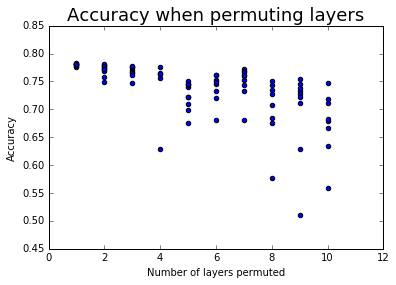

In [9]:
fig,ax = plot_experiment(only_permute(all_experiments()),
                         xfun = lambda exp: len(exp['permute']),
                         xlabel = 'Number of layers permuted',
                         title = 'Accuracy when permuting layers'
)

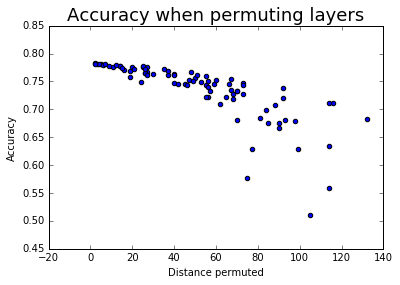

In [93]:
fig,ax = plot_experiment(only_permute(all_experiments()),
                         xfun = lambda e: (float(sum(abs(b-a) for b,a in e['permute']))),
                         xlabel = 'Distance permuted',
                         title = 'Accuracy when permuting layers'
) 
#ax.set_ylim([0.66, 0.8])


In [0]:
for exp in only_permute(all_experiments()):
    print exp['permute']

# Monitor training

In [18]:
%pylab inline
import lab_workbook
import pandas as pd
import collections
wb = lab_workbook.ExperimentRepository()

Populating the interactive namespace from numpy and matplotlib


In [57]:
experiments = collections.OrderedDict([
    ## ("201604291727-yVXYFcNR6W", "Pre-resnet, depth = 20"),
    ## ("201604291731-rn3CpTdqeL", "Pre-resnet, depth = 32"),
    ## ("201604291732-QslicJIuqp", "Pre-resnet, depth = 44"),
    ## ("201604291732-Xqkr0EN2aU", "Pre-resnet, depth = 56"),
    ("201604300038-N15yIkvxtk", "Pre-resnet, depth = 110"),
    ## ("201604291836-BSWMs4wb3X", "Stochastic depth, depth=20, p=0.5 flat"),
    ## ("201604300039-3VMAL8RMke", "Stochastic depth, depth=32, p=0.5 flat"),
    ## ("201604300040-TzOX3iXtYq", "Stochastic depth, depth=44, p=0.5 flat"),
    ## ("201604300040-UeF6Kn3O7a", "Stochastic depth, depth=56, p=0.5 flat"),
    #("201604300041-1jslpH48IF", "Stochastic depth, depth=110, p=0.5 flat"),
    # ("201604301624-d2WjgyKvEr", "Stochastic depth, depth=110, p=linear up to 0.1"),
    #("201604301556-QRF4XWMsYs", "Stochastic depth, depth=110, p=linear up to 0.5"),
    # ("201604301627-IdIvqfrFzp", "Stochastic depth, depth=110, p=linear up to 0.8"),
    #("201604301635-VTB2HPcviz", "Stochastic ORIGINAL resnet, depth=110, p=linear up to 0.5"),
    #("201605011325-QrNU5qyCqw", "Stochastic depth 110, SD code, d=0.5"),
    #("201605011326-RIbKcl59Ct", "Resnet 110, SD code, d=0.0"),
    #("201605021319-1IONyn4YoO", "Stochastic depth 56, SD code, d=0.5"),
    #("201605021320-z6sLdQC8Wk", "Stochastic depth 32, SD code, d=0.5"),
    #("201605021321-5YS8RgUYfJ", "Stochastic depth 20, SD code, d=0.5"),
    #th main.lua -dataset cifar10 -batchSize 128 -depth 20 -netType preresnet
    #th main.lua -dataset cifar10 -batchSize 128 -depth 110 -netType stochastic-preresnet -deathRateScale 0.8
    # SD code: th main.lua -dataRoot cifar.torch/ -resultFolder results -deathRate 0.0 -N 3
    ])
df_loss = wb.meld_csv(experiments, "Training loss.csv","loss")


In [20]:
wb["201605011325-QrNU5qyCqw"]['opt.json']

{u'N': 18,
 u'augmentation': True,
 u'batchSize': 128,
 u'dataRoot': u'cifar.torch/',
 u'dataset': u'cifar10',
 u'deathMode': u'lin_decay',
 u'deathRate': 0.5,
 u'device': 0,
 u'maxEpochs': 500,
 u'resultFolder': u'results/'}

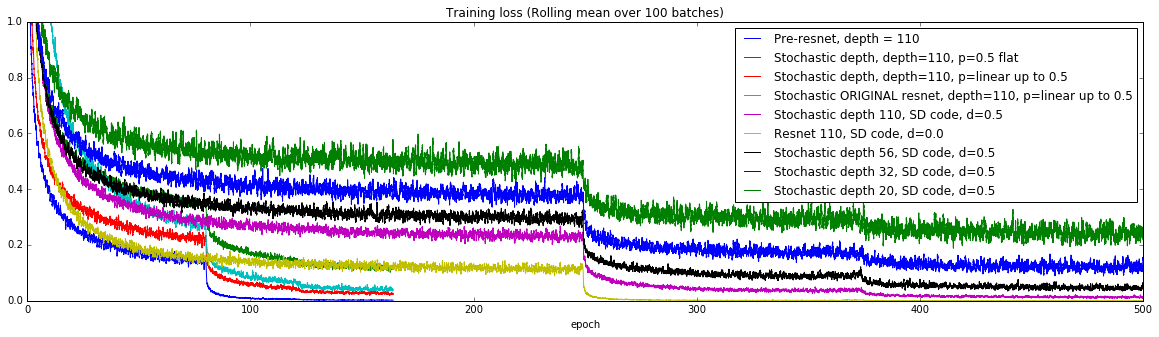

In [58]:
ax = pd.rolling_mean(df_loss, 100).plot(
    title="Training loss (Rolling mean over 100 batches)", figsize=(20,5),
    ylim = (0, 1.0),
    #xlim = (0, 100),
)


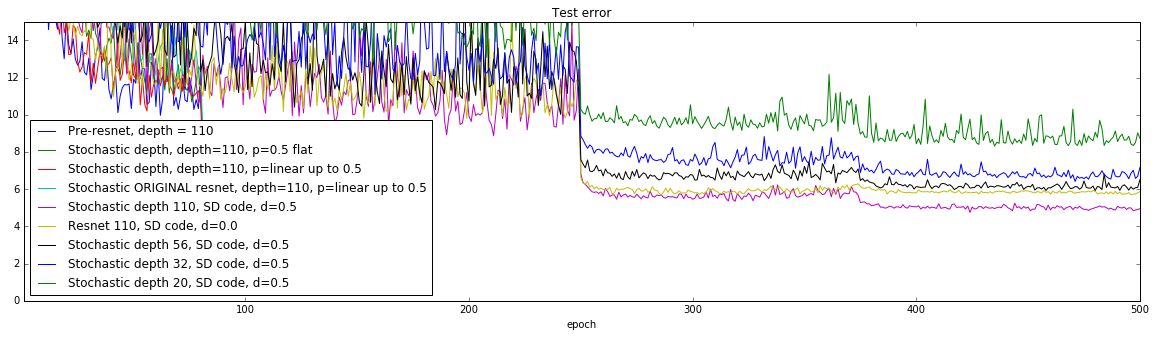

In [59]:
df_err = wb.meld_csv(experiments, "Test error.csv","top1")
df_err.plot(
    title="Test error", figsize=(20,5),
    ylim = (0, 15),
    #xlim = (0, 15),
)

In [61]:
df_err.min() # CHEEEEEETER

Pre-resnet, depth = 110                                      5.824763
Stochastic depth, depth=110, p=0.5 flat                      6.714794
Stochastic depth, depth=110, p=linear up to 0.5              6.220332
Stochastic ORIGINAL resnet, depth=110, p=linear up to 0.5    7.060918
Stochastic depth 110, SD code, d=0.5                         4.750000
Resnet 110, SD code, d=0.0                                   5.700000
Stochastic depth 56, SD code, d=0.5                          5.930000
Stochastic depth 32, SD code, d=0.5                          6.420000
Stochastic depth 20, SD code, d=0.5                          8.320000
dtype: float64